In [163]:
import pdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format='retina'
plt.rcParams["figure.dpi"] = 100
sns.set(style='darkgrid')

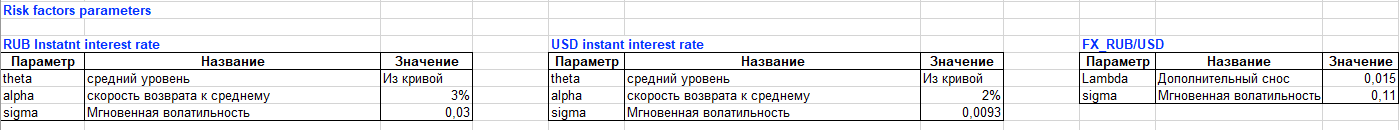

Задача: симуляция процентных ставок для рубля, доллара, а также обменного курса

Этапы:

1. Выбор способа интерполяции кривых процентных ставок
2. Симуляция процентных ставок
3. Симуляция процентных ставок и обменного курса с использованием коррелированных процессов 

**Модель процесса для процентной ставки** - Процесс Халла-Вайта:

$$dr(t) = (\theta(t) - \alpha r(t))dt + \sigma dW_t,$$

где $\theta(t)$ - средняя ожидаемая ставка в момент t (значения кривой)

$\alpha, \sigma$ - даны по условию задачи

Симуляции методом Эйлера-Маруямы:

$$r(t + \Delta t) = r(t) + (\theta(t) - \alpha r(t)\Delta t + \sigma \Delta W_t$$

**Модель процесса обменного курса**:

$$\frac{dX(t)}{X(t)} = (r_{foreign}(t) - r_{domestic}(t)+ \lambda)dt + \sigma dW_t$$

Симуляции методом Эйлера-Маруямы:

$$ X(t + \Delta t) = X(t) + X(t)(r_{foreign}(t) - r_{domestic}(t) + \lambda)\Delta t + X(t)\sigma \Delta W(t)$$ 

In [148]:
def read_curve_excel(path):
    df = pd.read_excel(path)
    df['Maturity'] = df['Maturity'].str[:-1]
    df['Maturity'] = df['Maturity'].astype(float)
    df['ds.rate'] /= 100
    
    return df

rub_irs = read_curve_excel('RUB IRS curve.xlsx')

usd_fra = read_curve_excel('USD FRA curve.xlsx')

#### Выбор интерполяции кривой

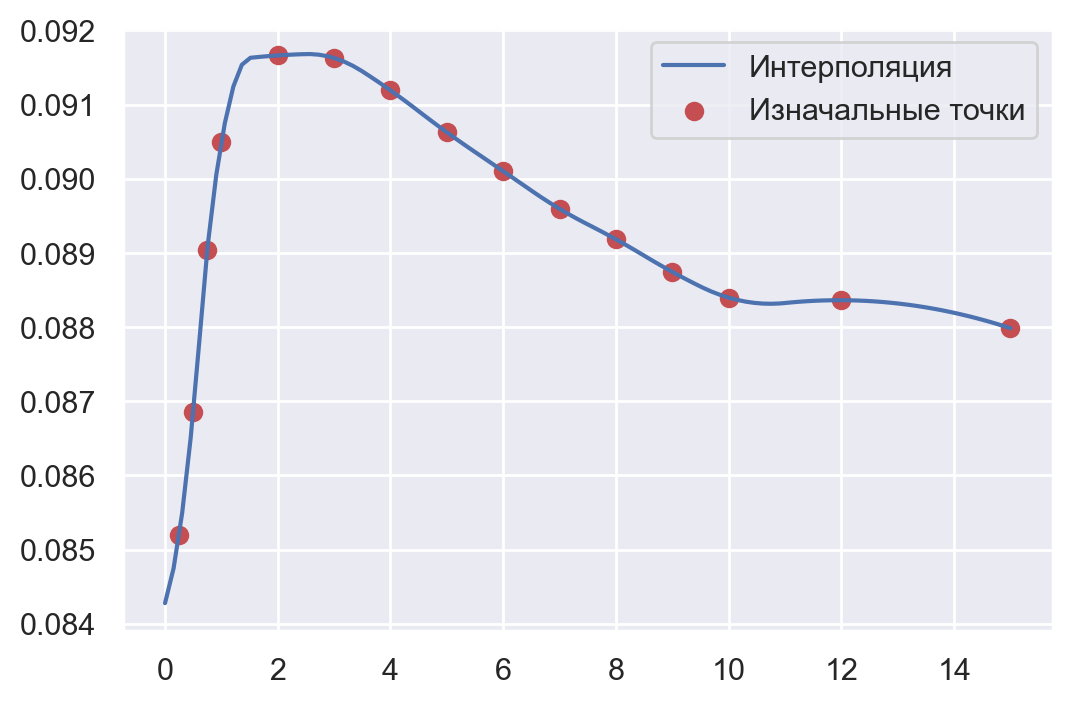

In [164]:
import scipy.interpolate as interpolate
theta = interpolate.interp1d(rub_irs['Maturity'], rub_irs['ds.rate'], fill_value='extrapolate', kind='quadratic')

x = np.linspace(0, 15, 100)
plt.scatter(rub_irs['Maturity'], rub_irs['ds.rate'], label='Изначальные точки', color='r')
plt.plot(x, theta(x), label='Интерполяция')
plt.legend();

In [166]:
def get_interpolation(curve_df):
    '''
    curve_df - pd.DataFrame со столбцом Maturity и ds.rate
    '''
    return interpolate.interp1d(curve_df['Maturity'], curve_df['ds.rate'], kind='quadratic', fill_value='extrapolate')

def generate_hull_white(curve_df, alpha, sigma, T, dt, num_traject=1, dW=None):
    '''
    curve_df - pd.DataFrame со столбцом Maturity и ds.rate
    T - конечный момент
    dt - шаг симуляции
    num_traject - колво траекторий
    dW - сгенерированные приросты винеровского процесса (для корреляции)
    '''
    theta = get_interpolation(curve_df)
    
    N = int(T / dt)
    if dW is None:
        dW = dt**.5*np.random.randn(num_traject, N-1)
    
    t = np.linspace(0, T, N)
    R = np.zeros((num_traject, N))
    for i, t_val in enumerate(t):
        if i == 0:
            R[:, i] = theta(t_val)
        else:
            
            prev_val = R[:, i-1]
            delta_theta = theta(t_val-dt)
            
            det_delta = (delta_theta - alpha*prev_val)*dt
            random_delta = sigma * dW[:, i-1]
            
            R[:, i] = prev_val + det_delta + random_delta
    
    return R, theta

#### Ставка rub

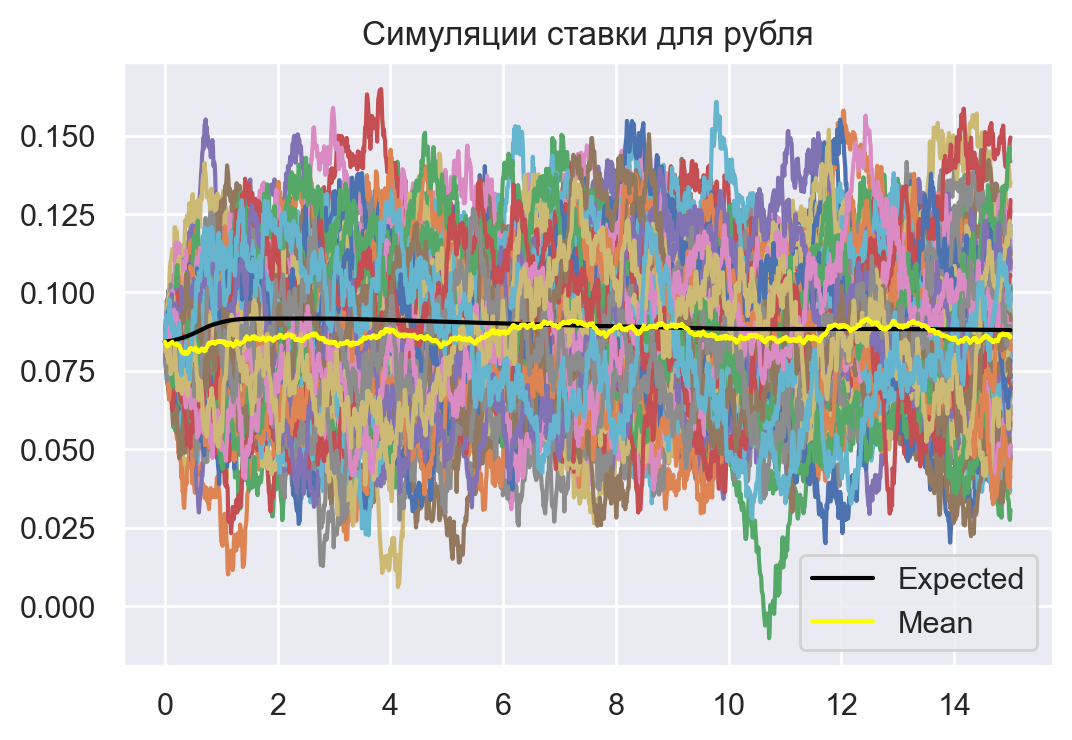

In [167]:
alpha_rub = 1.03
sigma_rub = 0.03

dt = 0.01
T = 15
num_traject = 100

R_rub, theta = generate_hull_white(rub_irs, alpha_rub, sigma_rub, T, dt, num_traject)
t = np.linspace(0, T, R_rub.shape[1])

for row in R_rub:
    plt.plot(t, row)
plt.plot(t, theta(t), label='Expected', color='black')
plt.plot(t, R_rub.mean(axis=0), label='Mean', color='yellow')
plt.title('Симуляции ставки для рубля')
plt.legend();

#### Ставка usd

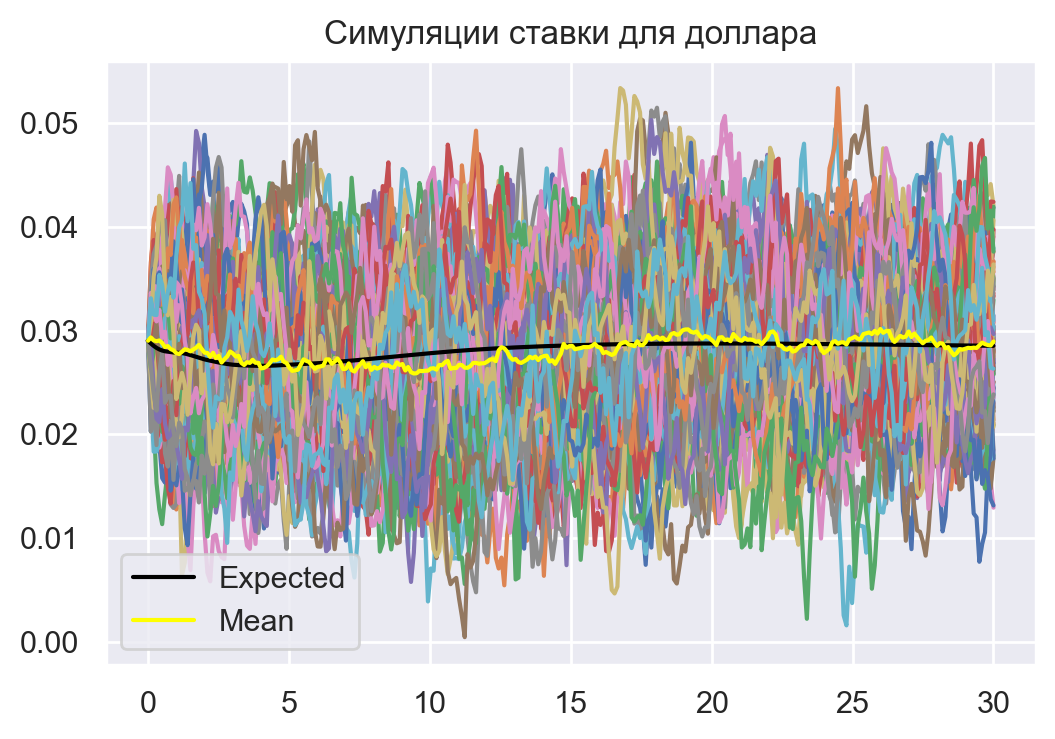

In [168]:
alpha_usd = 1.02
sigma_usd = 0.0093

dt = 0.1
T = 30
num_traject = 100

R_usd, theta = generate_hull_white(usd_fra, alpha_usd, sigma_usd, T, dt, num_traject)
t = np.linspace(0, T, R_usd.shape[1])

for row in R_usd:
    plt.plot(t, row)
plt.plot(t, theta(t), label='Expected', color='black')
plt.plot(t, R_usd.mean(axis=0), label='Mean', color='yellow')
plt.title('Симуляции ставки для доллара')
plt.legend();

#### Скоррелированные ставки и обменный курс

In [150]:
def get_correlated_rvs(*vals, C, sigmas=None):
    '''
    vals - векторы реализаций случайных величин
    C - матрица корреляций
    sigmas - tuple стандартных отклонений для сл величин
    '''
    if sigmas is None:
        sigmas = np.eye(len(vals))
    else:
        sigmas = np.diag([*sigmas])
    
    L = np.linalg.cholesky(C)
    corr_transform = sigmas @ L
    
    # Мы берем каждый набор реализаций (1 реализация от первой св, 1 реализация от второй и тд)
    # и засовываем их в 3-мерную матрицу (матрица[:, :, 0] возьмет первый такой набор, матрица[:, :, 1] второй)
    three_di_matrix = np.transpose(np.stack(vals), (1, 0, 2))
    # Для создания коррелированности между св мы каждый набор умножаем на матрицу corr_transform 
    # (благодаря broadcasting)
    three_di = corr_transform @ three_di_matrix
    # Собираем скорреллированные реализация в том виде, в каком они были до этого
    # (для каждой св своя матрица реализаций)
    # rot90 поворачивает матрицу так, что матрица[:, :, i] содержит то что нам надо,
    # но в обратном порядке
    vals = list(np.rot90(three_di))[::-1]
    
    return vals

In [159]:
def generate_correlated_processes(curve_dom, curve_for,
                                  alpha_dom, sigma_dom,
                                  alpha_for, sigma_for,
                                  X_0, lbda, sigma, C, T, dt, num_traject=1):
    '''
    curve_dom и curve_for - датафреймы кривых ставок 
    alpha_dom, sigma_dom, alpha_for, sigma_for - параметры их процессов
    X_0, lbda, sigma - параметры процесса обменного курса
    C - матрица корреляций между ставками и обменным курсом
    '''
    
    N = int(T / dt)
    
    dW_dom, dW_for, dW_exc = list(dt**.5 * np.random.randn(3, num_traject, N-1))
    dW_dom, dW_for, dW_exc = get_correlated_rvs(dW_dom, dW_for, dW_exc, C=C)
    
    R_dom, theta_dom = generate_hull_white(curve_dom, alpha_dom, sigma_dom, T, dt, num_traject, dW=dW_dom)
    R_for, theta_for = generate_hull_white(curve_for, alpha_for, sigma_for, T, dt, num_traject, dW=dW_for)
    
    t = np.linspace(0, T, N)
    X = np.zeros((num_traject, N))
    
    for i, _ in enumerate(t):
        if i == 0:
            X[:, i] = X_0
        else:
            
            prev_val = X[:, i-1]
            
            det_delta = prev_val * (R_for[:, i-1] - R_dom[:, i-1] + lbda) * dt
            random_delta = prev_val * sigma * dW_exc[:, i-1]
            
            X[:, i] = prev_val + det_delta + random_delta
    
    return R_dom, theta_dom, R_for, theta_for, X

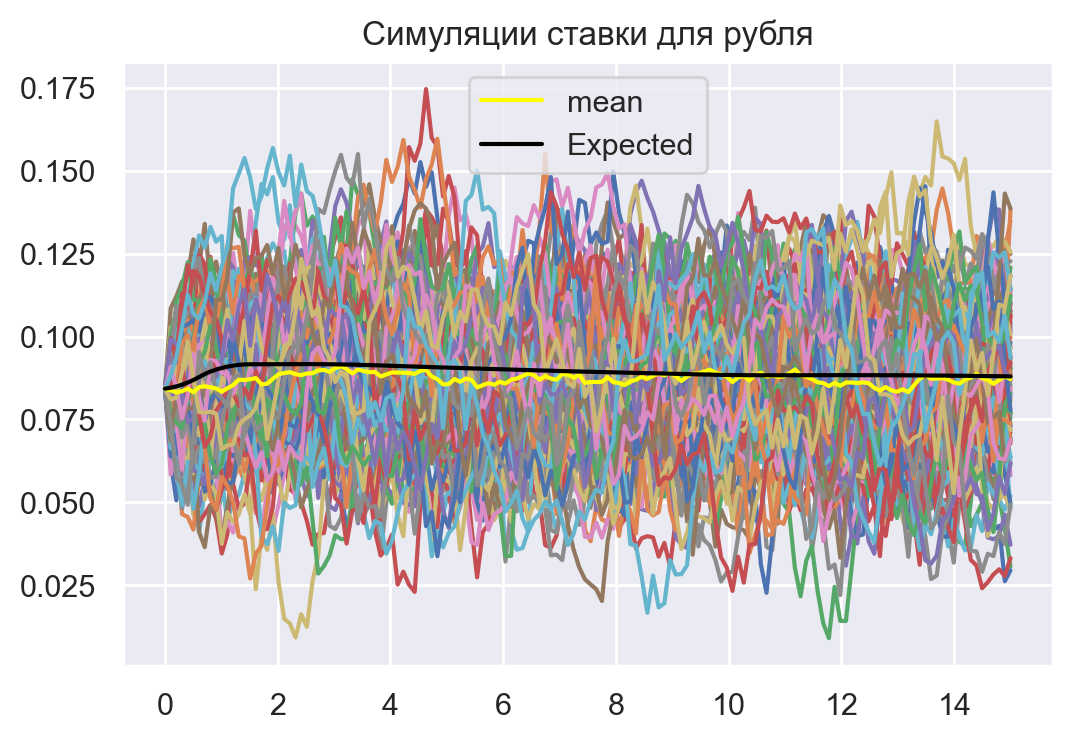

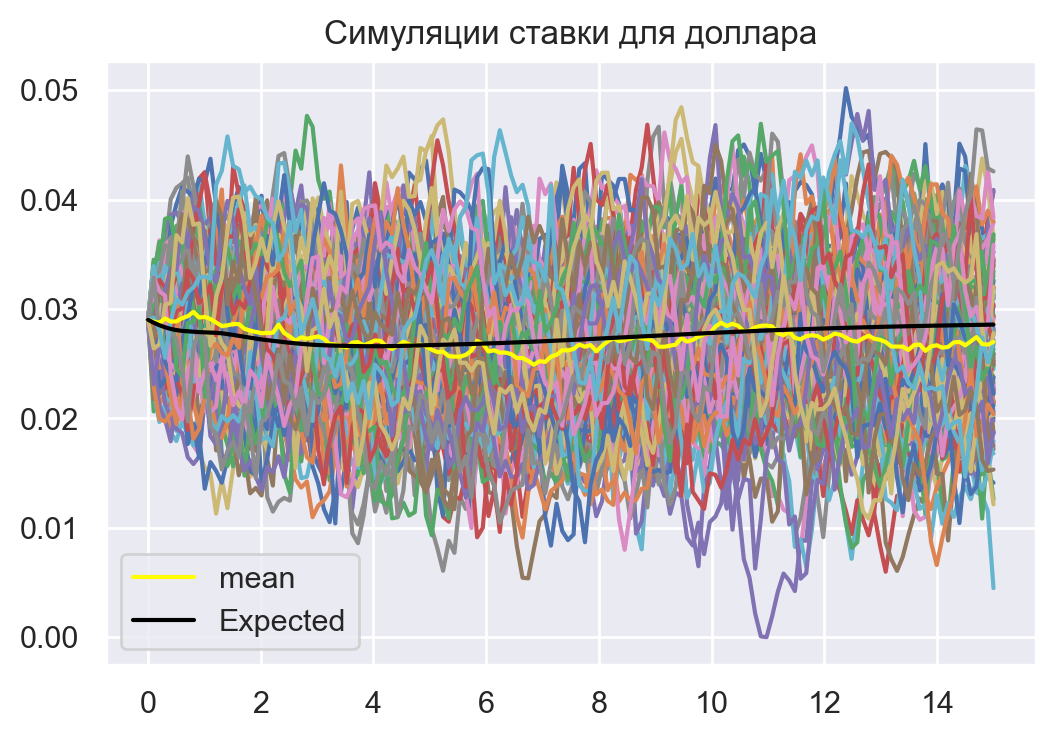

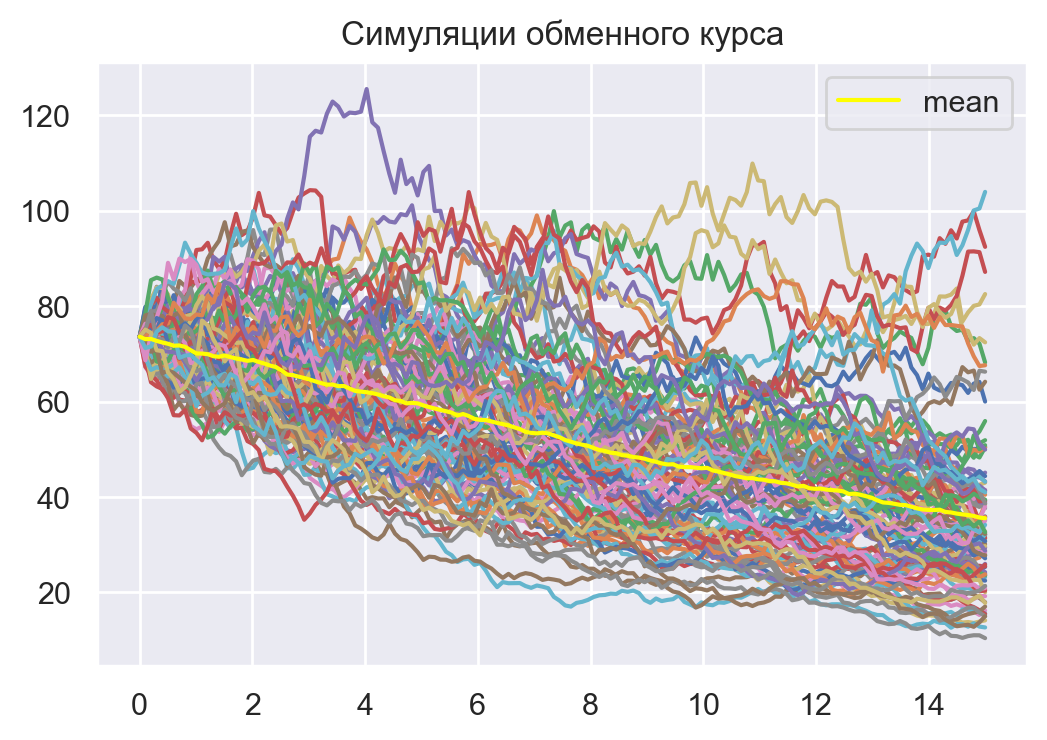

In [169]:
X0 = 73.6
lbda_exc = 0.015
sigma_exc = 0.11

dt = 0.1
T = 15
num_traject = 100

# Посчитано в ноутбуке с соответствующим названием
C = np.array([[1, 0.021, -0.11],
              [0.021, 1, 0.055],
              [-0.11, 0.055, 1]])  

R_rub, theta_rub, R_usd, theta_usd, X = generate_correlated_processes(
    rub_irs, usd_fra, 
    alpha_rub, sigma_rub,
    alpha_usd, sigma_usd, 
    X0, lbda_exc, sigma_exc, 
    C, T, dt, num_traject
)
t = np.linspace(0, T, X.shape[1])

for row in R_rub:
    plt.plot(t, row)
plt.plot(t, R_rub.mean(axis=0), color='yellow', label='mean')
plt.plot(t, theta_rub(t), label='Expected', color='black')
plt.title('Симуляции ставки для рубля')
plt.legend()
plt.show()

for row in R_usd:
    plt.plot(t, row)
plt.plot(t, R_usd.mean(axis=0), color='yellow', label='mean')
plt.plot(t, theta_usd(t), label='Expected', color='black')
plt.title('Симуляции ставки для доллара')
plt.legend()
plt.show()

for row in X:
    plt.plot(t, row)
plt.plot(t, X.mean(axis=0), color='yellow', label='mean')
plt.title('Симуляции обменного курса')
plt.legend();